##Importando as bibliotecas

In [5]:
#Baixando as bibliotecas
!pip install transformers torch scikit-learn pandas

In [6]:
#importando
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset


##Carregamento e visualização dos dados

In [7]:
# Carregar a base de dados
df = pd.read_csv('/content/bot_detection_data.csv')

### Visualizar as primeiras linhas do dataset


In [8]:
print(df.head())

   User ID        Username                                              Tweet  \
0   132131           flong  Station activity person against natural majori...   
1   289683  hinesstephanie  Authority research natural life material staff...   
2   779715      roberttran  Manage whose quickly especially foot none to g...   
3   696168          pmason  Just cover eight opportunity strong policy which.   
4   704441          noah87                      Animal sign six data good or.   

   Retweet Count  Mention Count  Follower Count  Verified  Bot Label  \
0             85              1            2353     False          1   
1             55              5            9617      True          0   
2              6              2            4363      True          0   
3             54              5            2242      True          1   
4             26              3            8438     False          1   

       Location           Created At            Hashtags  
0     Adkinston  2020

**Estrutura dos dados**: Os dados contêm as seguintes colunas principais:User ID: ID do usuário. <br/>
Username: Nome de usuário no Twitter. <br/>
Tweet: Conteúdo do tweet. <br/>
Retweet Count: Número de retweets do tweet. <br/>
Mention Count: Número de menções no tweet.<br/>
Follower Count: Contagem de seguidores do usuário.<br/>
Verified: Se o usuário é verificado (True) ou não (False).<br/>
Bot Label: Rótulo binário indicando se o usuário é um bot (1) ou não (0).<br/>
Location: Localização do usuário.<br/>
Created At: Data de criação do tweet.<br/>
Hashtags: Hashtags presentes no tweet.<br/>

###Simplificando a base

Simplifiquei a base para conseguir fazer o treinamento no collab

In [9]:
df = df.sample(frac=0.1, random_state=42)

###Visualizando os tipos de dados

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 33553 to 20382
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User ID         5000 non-null   int64 
 1   Username        5000 non-null   object
 2   Tweet           5000 non-null   object
 3   Retweet Count   5000 non-null   int64 
 4   Mention Count   5000 non-null   int64 
 5   Follower Count  5000 non-null   int64 
 6   Verified        5000 non-null   bool  
 7   Bot Label       5000 non-null   int64 
 8   Location        5000 non-null   object
 9   Created At      5000 non-null   object
 10  Hashtags        4236 non-null   object
dtypes: bool(1), int64(5), object(5)
memory usage: 434.6+ KB


### Visualizando a quantidade de nulos

In [11]:
df.isnull().sum()

,0
User ID,0
Username,0
Tweet,0
Retweet Count,0
Mention Count,0
Follower Count,0
Verified,0
Bot Label,0
Location,0
Created At,0


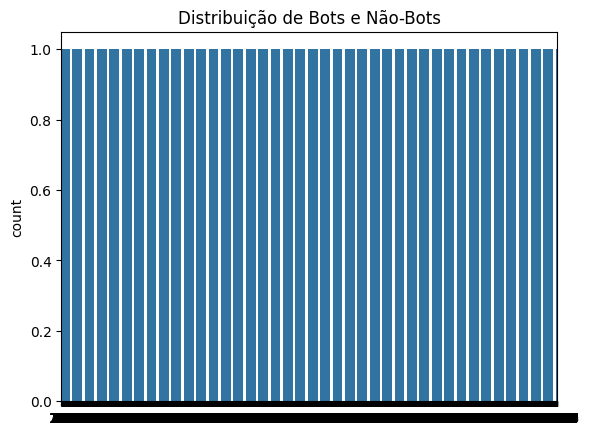

In [12]:
# Distribuição de bots (rótulos)
sns.countplot(df['Bot Label'])
plt.title('Distribuição de Bots e Não-Bots')
plt.show()


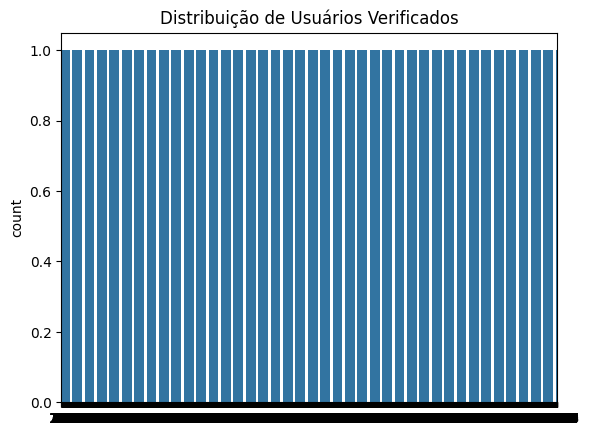

In [13]:
# Distribuição de usuários verificados
sns.countplot(df['Verified'])
plt.title('Distribuição de Usuários Verificados')
plt.show()


In [14]:
# Selecionar apenas colunas numéricas
df_numerico = df.select_dtypes(include=['float64', 'int64'])
df_numerico

,User ID,Retweet Count,Mention Count,Follower Count,Bot Label
33553,715347,83,0,7074,1
9427,810631,55,4,6242,1
199,529620,86,5,2553,0
12447,599472,3,0,7752,0
39489,459712,38,1,8029,0
...,...,...,...,...,...
39885,513327,93,5,1544,0
17566,320658,4,3,8246,0
16062,369477,58,1,255,0
48445,558659,99,2,4547,1


### Preencher valores nulos na coluna de Hashtags com uma string vazia

In [15]:

df['Hashtags'].fillna('', inplace=True)

# Conferir valores nulos restantes
print(df.isnull().sum())


User ID           0
Username          0
Tweet             0
Retweet Count     0
Mention Count     0
Follower Count    0
Verified          0
Bot Label         0
Location          0
Created At        0
Hashtags          0
dtype: int64


<ipython-input-15-0677c82512bd>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Hashtags'].fillna('', inplace=True)


### Usar LabelEncoder para variáveis categóricas


In [16]:
encoder = LabelEncoder()

df['Location'] = encoder.fit_transform(df['Location'])
df['Verified'] = df['Verified'].astype(int)


### Normalizar variáveis numéricas como 'Retweet Count' e 'Follower Count'

In [17]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Retweet Count', 'Mention Count', 'Follower Count']] = scaler.fit_transform(df[['Retweet Count', 'Mention Count', 'Follower Count']])


### Definir as features (recursos) e os rótulo

In [18]:

features = df[['Tweet', 'Retweet Count', 'Mention Count', 'Follower Count', 'Verified', 'Location', 'Hashtags']]
labels = df['Bot Label'].values


### Dividir os dados em treino (80%) e teste (20%)

In [19]:

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

print(f"Tamanho do conjunto de treino: {len(train_features)}")
print(f"Tamanho do conjunto de teste: {len(test_features)}")


Tamanho do conjunto de treino: 4000
Tamanho do conjunto de teste: 1000


### Carregar o tokenizer do BERT


In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Tokenizar os tweets de treino e teste


In [21]:
train_encodings = tokenizer(list(train_features['Tweet']), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_features['Tweet']), truncation=True, padding=True, max_length=128)


### Converter encodings e rótulos em tensores para PyTorch

In [22]:

train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels)
)


### Preparar DataLoader para gerenciamento do treinamento


In [23]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### Carregar o modelo BERT para classificação


In [24]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Colocar o modelo em modo de treinamento
model.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Definir o otimizador

In [25]:
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


###Rodando o modelo

In [28]:
epochs = 5  # Número de épocas

for epoch in range(epochs):
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch

        # Zerar os gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Atualizar os parâmetros
        optimizer.step()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader)}")


Epoch 1 - Loss: 0.7066886265277863
Epoch 2 - Loss: 0.7016312062740326
Epoch 3 - Loss: 0.6985800392627716
Epoch 4 - Loss: 0.7063502306938172
Epoch 5 - Loss: 0.7011710333824158


### Avaliação do modelo

In [32]:
model.eval()  # Colocar o modelo em modo de avaliação

predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch

        # Forward pass sem cálculo de gradientes
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Obter as previsões
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

# Calcular a acurácia
accuracy = accuracy_score(true_labels, predictions)
print(f"Acurácia: {accuracy}")

# Relatório detalhado de métricas
report = classification_report(true_labels, predictions, target_names=['Não-Bot', 'Bot'], output_dict=True)

# Exibir o relatório de métricas
print(f"Acurácia: {accuracy}")
print(classification_report(true_labels, predictions, target_names=['Não-Bot', 'Bot']))


Acurácia: 0.531
Acurácia: 0.531
              precision    recall  f1-score   support

     Não-Bot       0.53      1.00      0.69       531
         Bot       0.00      0.00      0.00       469

    accuracy                           0.53      1000
   macro avg       0.27      0.50      0.35      1000
weighted avg       0.28      0.53      0.37      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay


# Plotar gráfico de barras com as principais métricas (precisão, recall, f1-score)
categories = ['Não-Bot', 'Bot']
metrics = ['precision', 'recall', 'f1-score']

# Organizar os dados para plot
precisions = [report[cat]['precision'] for cat in categories]
recalls = [report[cat]['recall'] for cat in categories]
f1_scores = [report[cat]['f1-score'] for cat in categories]


In [39]:
print(precisions, recalls, f1_scores)

[0.531, 0.0] [1.0, 0.0] [0.6936642717178315, 0.0]


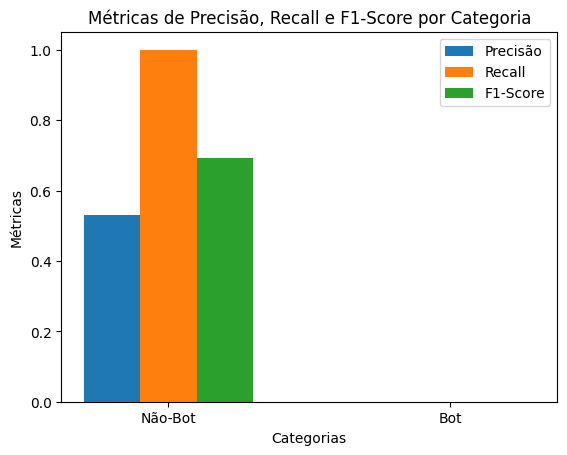

In [36]:

# Configuração do gráfico de barras
x = range(len(categories))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar([i - width for i in x], precisions, width, label='Precisão')
rects2 = ax.bar(x, recalls, width, label='Recall')
rects3 = ax.bar([i + width for i in x], f1_scores, width, label='F1-Score')

# Adicionar rótulos e títulos
ax.set_xlabel('Categorias')
ax.set_ylabel('Métricas')
ax.set_title('Métricas de Precisão, Recall e F1-Score por Categoria')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

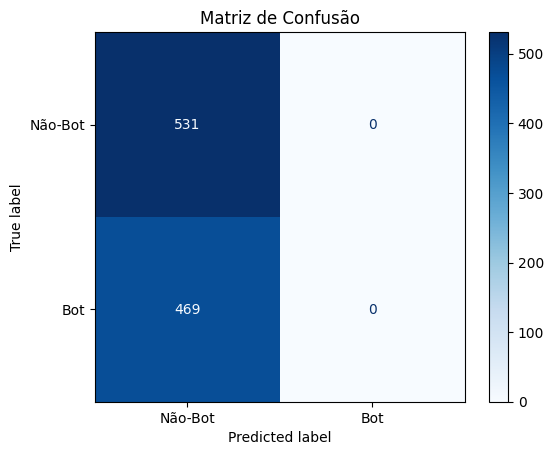

In [37]:
# Plotar matriz de confusão
ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=categories, cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

In [38]:
print(matriz)